In [1]:
%cd /home/ubuntu/statefarm
from theano.sandbox import cuda
cuda.use('gpu0')
%matplotlib inline
from __future__ import print_function, division
path = "/home/ubuntu/statefarm/"
#path = '/home/ubuntu/statefarm/sample/'
import utils; reload(utils)
from utils import *
from IPython.display import FileLink

import skimage
from skimage import exposure, io
#import cv2
import glob
import matplotlib.image as mpimg
#from imutils.object_detection import non_max_suppression

/home/ubuntu/statefarm


Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


# First, make the validation set with *different* drivers

In [ ]:
%%bash
cut -f 1 -d ',' driver_imgs_list.csv | grep -v subject | uniq -c
lines=$(expr `wc -l driver_imgs_list.csv | cut -f 1 -d ' '` - 1)
echo "Got ${lines} pics"

fastai's statefarm has 3478 pics in validation set and 18946 in training, so let's get something close to that

In [ ]:
import csv
import os
to_get = set(['p081','p075', 'p072', 'p066', 'p064'])
with open('driver_imgs_list.csv') as f:
    next(f)
    for line in csv.reader(f):
        if line[0] in to_get:
            if os.path.exists('train/%s/%s' %(line[1], line[2])):
                os.popen('mv train/%s/%s valid/%s/%s'%(line[1], line[2], line[1], line[2]))

import glob
print('Training has', len(glob.glob('train/*/*jpg')))
print('Validation has', len(glob.glob('valid/*/*jpg')))

# Now let's make a sample set

In [ ]:
%%bash
mkdir /home/ubuntu/statefarm/sample
mkdir /home/ubuntu/statefarm/sample/train
for i in {0..9}; do mkdir /home/ubuntu/statefarm/sample/train/c${i}; done
mkdir /home/ubuntu/statefarm/sample/valid
for i in {0..9}; do mkdir /home/ubuntu/statefarm/sample/valid/c${i}; done
mkdir /home/ubuntu/statefarm/sample/test
for i in {0..9}; do mkdir /home/ubuntu/statefarm/sample/test/c${i}; done

In [ ]:
from shutil import copyfile
%cd /home/ubuntu/statefarm/train
g = glob.glob('c?/*.jpg')
shuf = np.random.permutation(g)
print(shuf[:5])
for i in range(1500): copyfile(shuf[i], '../sample/train/' + shuf[i])

In [ ]:
%cd ../valid
g = glob.glob('c?/*.jpg')
shuf = np.random.permutation(g)
for i in range(1000): copyfile(shuf[i], '../sample/valid/' + shuf[i])

In [ ]:
%%bash
find /home/ubuntu/statefarm/sample/valid -type f | wc -l
find /home/ubuntu/statefarm/sample/train -type f | wc -l

# So we made a sample set now, hooray, now starts the actual work

In [2]:
batch_size = 64

gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)

trn_batches = get_batches(path+'train', gen_t, batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

Found 18587 images belonging to 10 classes.
Found 3837 images belonging to 10 classes.


In [3]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(10)

THE FOLLOWING TAKES FOREVER - TAKES MOST OF MEMORY

In [4]:
def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range(batches.nb_sample)])

#trn = np.concatenate([trn_batches.next() for i in range(trn_batches.nb_sample)])
#val = np.concatenate([val_batches.next() for i in range(val_batches.nb_sample)])

In [5]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
model.fit_generator(trn_batches, trn_batches.N, nb_epoch=3, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/3
18587/18587 [==============================] - 529s - loss: 2.8905 - acc: 0.4375 - val_loss: 2.6881 - val_acc: 0.4347
Epoch 2/3
18587/18587 [==============================] - 528s - loss: 1.9522 - acc: 0.5825 - val_loss: 3.3446 - val_acc: 0.4131
Epoch 3/3
18587/18587 [==============================] - 528s - loss: 1.7955 - acc: 0.6168 - val_loss: 3.1469 - val_acc: 0.4243


In [7]:
model.optimizer.lr = 1e-5
model.fit_generator(trn_batches, trn_batches.N, nb_epoch=3, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/3
18587/18587 [==============================] - 529s - loss: 1.7691 - acc: 0.6259 - val_loss: 3.8609 - val_acc: 0.3998
Epoch 2/3
18587/18587 [==============================] - 528s - loss: 1.7536 - acc: 0.6351 - val_loss: 4.1521 - val_acc: 0.3928
Epoch 3/3
18587/18587 [==============================] - 528s - loss: 1.7390 - acc: 0.6414 - val_loss: 3.8339 - val_acc: 0.3745


In [8]:
last_conv_idx = [i for i,l in enumerate(model.layers) if type(l) is Convolution2D][-1]
conv_layers = model.layers[:last_conv_idx+1]

In [9]:
conv_model = Sequential(conv_layers)

In [10]:
trn_batches = get_batches(path+'train', gen_t, batch_size=batch_size, shuffle=False)

conv_feat = conv_model.predict_generator(trn_batches, trn_batches.nb_sample)
conv_val_feat = conv_model.predict_generator(val_batches, val_batches.nb_sample)


Found 18587 images belonging to 10 classes.


In [11]:
print(trn_batches.N)
print(trn_batches.nb_sample)

18587
18587


In [12]:
%cd /home/ubuntu/statefarm
#%mkdir results

save_array(path+'results/conv_val_feat.dat', conv_val_feat)
save_array(path+'results/conv_feat.dat', conv_feat)
#print(type(conv_feat))

conv_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')
print(type(conv_feat))

/home/ubuntu/statefarm
<type 'numpy.ndarray'>


In [13]:

#print(conv_layers[-1].output_shape)
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(10, activation='softmax')
        ]



In [14]:
p = 0.7

In [15]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)


Found 18587 images belonging to 10 classes.
Found 3837 images belonging to 10 classes.
Found 0 images belonging to 0 classes.


In [16]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=1, 
             validation_data=(conv_val_feat, val_labels))


Train on 18587 samples, validate on 3837 samples
Epoch 1/1
18587/18587 [==============================] - 9s - loss: 1.8820 - acc: 0.4773 - val_loss: 1.2765 - val_acc: 0.6169


In [18]:
bn_model.optimizer.lr = 1e-7
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 18587 samples, validate on 3837 samples
Epoch 1/7
18587/18587 [==============================] - 9s - loss: 0.6159 - acc: 0.7958 - val_loss: 1.1565 - val_acc: 0.6646
Epoch 2/7
18587/18587 [==============================] - 9s - loss: 0.4305 - acc: 0.8584 - val_loss: 1.2436 - val_acc: 0.6547
Epoch 3/7
18587/18587 [==============================] - 9s - loss: 0.3349 - acc: 0.8907 - val_loss: 1.1437 - val_acc: 0.6875
Epoch 4/7
18587/18587 [==============================] - 9s - loss: 0.2748 - acc: 0.9095 - val_loss: 1.0642 - val_acc: 0.7149
Epoch 5/7
18587/18587 [==============================] - 9s - loss: 0.2462 - acc: 0.9192 - val_loss: 1.3050 - val_acc: 0.6685
Epoch 6/7
18587/18587 [==============================] - 9s - loss: 0.2278 - acc: 0.9245 - val_loss: 1.1947 - val_acc: 0.6935
Epoch 7/7
18587/18587 [==============================] - 9s - loss: 0.2089 - acc: 0.9310 - val_loss: 1.3109 - val_acc: 0.6583


# Let's clean the picture and crop humans

train/c7/img_21066.jpg


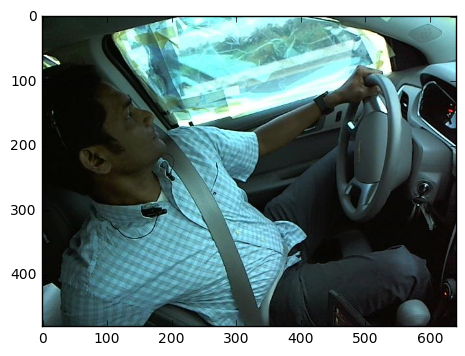

In [4]:
img = glob.glob('train/*/*jpg')[100]
print(img)
plt.imshow(mpimg.imread(img))

/home/ubuntu/anaconda2/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


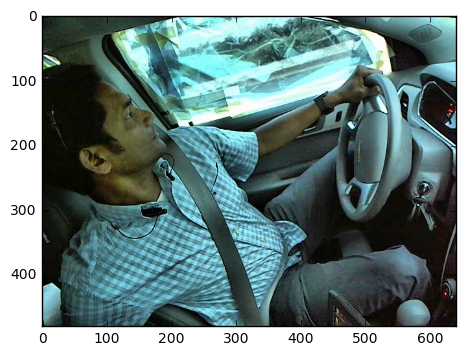

In [5]:
cleaned = exposure.equalize_adapthist(mpimg.imread(img))
plt.imshow(cleaned)

train/c7/img_75886.jpg


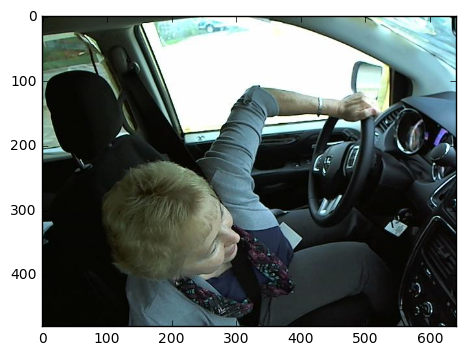

In [6]:
img = glob.glob('train/*/*jpg')[1000]
print(img)
plt.imshow(mpimg.imread(img))

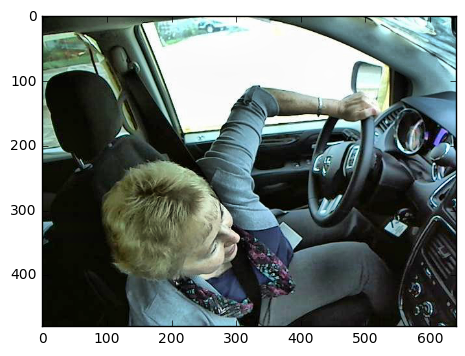

In [7]:
cleaned = exposure.equalize_adapthist(mpimg.imread(img))
plt.imshow(cleaned)

train/c4/img_53559.jpg


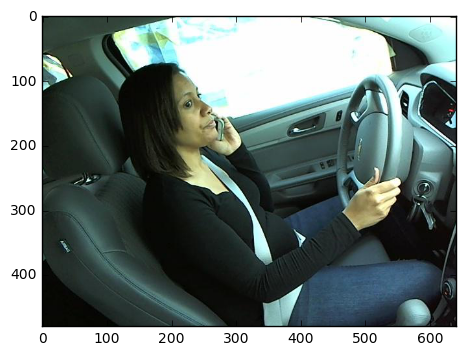

In [8]:
img = glob.glob('train/*/*jpg')[10000]
print(img)
plt.imshow(mpimg.imread(img))

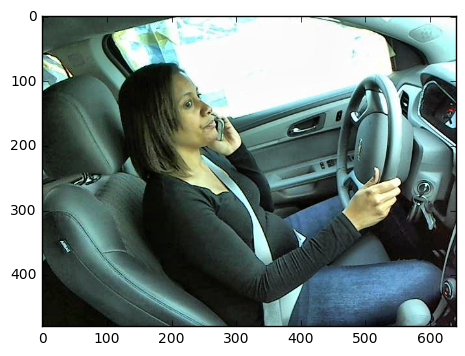

In [13]:
cleaned = exposure.equalize_adapthist(mpimg.imread(img))
io.imsave('hi.png', cleaned)
plt.imshow(mpimg.imread('hi.png'))

In [18]:
%%bash
mkdir cleaned
mkdir cleaned/train
mkdir cleaned/test
mkdir cleaned/valid
for i in {0..9}; do mkdir /home/ubuntu/statefarm/cleaned/train/c${i}; done
for i in {0..9}; do mkdir /home/ubuntu/statefarm/cleaned/valid/c${i}; done
for i in {0..9}; do mkdir /home/ubuntu/statefarm/cleaned/test/c${i}; done

mkdir: cannot create directory ‘cleaned’: File exists
mkdir: cannot create directory ‘cleaned/train’: File exists
mkdir: cannot create directory ‘cleaned/test’: File exists
mkdir: cannot create directory ‘cleaned/valid’: File exists


In [20]:
for img in glob.glob('train/*/*jpg'):
    cleaned = exposure.equalize_adapthist(mpimg.imread(img))
    out = 'cleaned/' + img
    io.imsave(out, cleaned)


In [21]:
for img in glob.glob('valid/*/*jpg'):
    cleaned = exposure.equalize_adapthist(mpimg.imread(img))
    out = 'cleaned/' + img
    io.imsave(out, cleaned)


In [2]:
path = "/home/ubuntu/statefarm/cleaned/"


In [2]:
batch_size = 64

gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)

trn_batches = get_batches(path+'train', gen_t, batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

Found 18587 images belonging to 10 classes.
Found 3837 images belonging to 10 classes.


In [3]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(10)

In [4]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
model.fit_generator(trn_batches, trn_batches.N, nb_epoch=3, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/3
18587/18587 [==============================] - 535s - loss: 2.9060 - acc: 0.4342 - val_loss: 2.8786 - val_acc: 0.4204
Epoch 2/3
18587/18587 [==============================] - 535s - loss: 1.9459 - acc: 0.5802 - val_loss: 2.7167 - val_acc: 0.4613
Epoch 3/3
18587/18587 [==============================] - 535s - loss: 1.8129 - acc: 0.6121 - val_loss: 3.2493 - val_acc: 0.3888


In [6]:
model.optimizer.lr = 1e-5
model.fit_generator(trn_batches, trn_batches.N, nb_epoch=3, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/3
18587/18587 [==============================] - 536s - loss: 1.7538 - acc: 0.6274 - val_loss: 3.7557 - val_acc: 0.3716
Epoch 2/3
18587/18587 [==============================] - 535s - loss: 1.7416 - acc: 0.6374 - val_loss: 4.2376 - val_acc: 0.3745
Epoch 3/3
18587/18587 [==============================] - 535s - loss: 1.7752 - acc: 0.6388 - val_loss: 3.4470 - val_acc: 0.4139


In [7]:
last_conv_idx = [i for i,l in enumerate(model.layers) if type(l) is Convolution2D][-1]
conv_layers = model.layers[:last_conv_idx+1]

In [8]:
conv_model = Sequential(conv_layers)

In [9]:
trn_batches = get_batches(path+'train', gen_t, batch_size=batch_size, shuffle=False)

conv_feat = conv_model.predict_generator(trn_batches, trn_batches.nb_sample)
conv_val_feat = conv_model.predict_generator(val_batches, val_batches.nb_sample)


Found 18587 images belonging to 10 classes.


In [10]:

#print(conv_layers[-1].output_shape)
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(10, activation='softmax')
        ]



In [11]:
p = 0.8

In [12]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)


Found 18587 images belonging to 10 classes.
Found 3837 images belonging to 10 classes.
Found 0 images belonging to 0 classes.


In [13]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=1, 
             validation_data=(conv_val_feat, val_labels))


Train on 18587 samples, validate on 3837 samples
Epoch 1/1
18587/18587 [==============================] - 12s - loss: 3.1433 - acc: 0.2395 - val_loss: 1.4523 - val_acc: 0.5486


In [15]:
bn_model.optimizer.lr = 1e-5
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 18587 samples, validate on 3837 samples
Epoch 1/7
18587/18587 [==============================] - 11s - loss: 1.4342 - acc: 0.5111 - val_loss: 1.2368 - val_acc: 0.6036
Epoch 2/7
18587/18587 [==============================] - 11s - loss: 0.9653 - acc: 0.6615 - val_loss: 1.1254 - val_acc: 0.6424
Epoch 3/7
18587/18587 [==============================] - 11s - loss: 0.7741 - acc: 0.7356 - val_loss: 1.0764 - val_acc: 0.6495
Epoch 4/7
18587/18587 [==============================] - 11s - loss: 0.6593 - acc: 0.7761 - val_loss: 1.0755 - val_acc: 0.6508
Epoch 5/7
18587/18587 [==============================] - 11s - loss: 0.5791 - acc: 0.8029 - val_loss: 1.0906 - val_acc: 0.6542
Epoch 6/7
18587/18587 [==============================] - 11s - loss: 0.5354 - acc: 0.8223 - val_loss: 1.0557 - val_acc: 0.6685
Epoch 7/7
18587/18587 [==============================] - 11s - loss: 0.4780 - acc: 0.8380 - val_loss: 0.9688 - val_acc: 0.7011


In [16]:
bn_model.optimizer.lr = 1e-7
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 18587 samples, validate on 3837 samples
Epoch 1/7
18587/18587 [==============================] - 11s - loss: 0.4556 - acc: 0.8507 - val_loss: 1.0277 - val_acc: 0.6875
Epoch 2/7
18587/18587 [==============================] - 11s - loss: 0.4418 - acc: 0.8533 - val_loss: 1.0240 - val_acc: 0.6867
Epoch 3/7
18587/18587 [==============================] - 11s - loss: 0.4123 - acc: 0.8632 - val_loss: 1.0370 - val_acc: 0.6789
Epoch 4/7
18587/18587 [==============================] - 11s - loss: 0.4082 - acc: 0.8650 - val_loss: 1.0002 - val_acc: 0.6925
Epoch 5/7
18587/18587 [==============================] - 11s - loss: 0.3866 - acc: 0.8701 - val_loss: 0.9778 - val_acc: 0.7013
Epoch 6/7
18587/18587 [==============================] - 11s - loss: 0.3740 - acc: 0.8778 - val_loss: 0.9198 - val_acc: 0.7253
Epoch 7/7
18587/18587 [==============================] - 11s - loss: 0.3663 - acc: 0.8814 - val_loss: 0.9478 - val_acc: 0.7217


In [17]:
bn_model.optimizer.lr = 1e-9
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 18587 samples, validate on 3837 samples
Epoch 1/7
18587/18587 [==============================] - 11s - loss: 0.3550 - acc: 0.8830 - val_loss: 0.9035 - val_acc: 0.7219
Epoch 2/7
18587/18587 [==============================] - 11s - loss: 0.3433 - acc: 0.8894 - val_loss: 1.0059 - val_acc: 0.7016
Epoch 3/7
18587/18587 [==============================] - 11s - loss: 0.3318 - acc: 0.8901 - val_loss: 0.9923 - val_acc: 0.7047
Epoch 4/7
18587/18587 [==============================] - 11s - loss: 0.3386 - acc: 0.8892 - val_loss: 1.0362 - val_acc: 0.6938
Epoch 5/7
18587/18587 [==============================] - 11s - loss: 0.3180 - acc: 0.8965 - val_loss: 1.0540 - val_acc: 0.6930
Epoch 6/7
18587/18587 [==============================] - 11s - loss: 0.3201 - acc: 0.8960 - val_loss: 1.0568 - val_acc: 0.6922
Epoch 7/7
18587/18587 [==============================] - 11s - loss: 0.3070 - acc: 0.8998 - val_loss: 0.9672 - val_acc: 0.7188


In [18]:
%mkdir models

mkdir: cannot create directory ‘models’: File exists


In [19]:
bn_model.save_weights(path+'models/bn_model.h5')
bn_model.load_weights(path+'models/bn_model.h5')

In [22]:
bn_feat = bn_model.predict(conv_feat, batch_size=batch_size)
bn_val_feat = bn_model.predict(conv_val_feat, batch_size=batch_size)

# Slightly better! Validation loss is sometimes under 1

Let's try something else - can I look at what the model predicts for the training set?

In [23]:
np.savetxt('train_predictions.csv', bn_feat)
np.savetxt('val_predictions.csv', bn_val_feat)

Let's have a look at the images with a 'bad' maximum probability, around 50% - 
how many training pictures do we have with bad probabilities?

In [25]:
bn_feat.shape

(18587, 10)

In [27]:
np.max(bn_feat[:,1])

0.99999785

Give me all training pictures that don't have a class 'probability' above 90%

In [37]:
np.where(np.amax(bn_feat, axis=1) < 0.9)

(array([   22,    45,    93,   145,   154,   248,   275,   374,   422,   426,   458,   467,   487,
          511,   538,   563,   607,   755,   792,   871,   884,   894,   944,   945,  1067,  1069,
         1234,  1396,  1472,  1571,  1580,  1585,  1626,  1659,  1720,  1913,  1928,  1941,  1949,
         1960,  2099,  2346,  2354,  2586,  2622,  2749,  3107,  3225,  3541,  3696,  4090,  4101,
         4266,  4273,  4861,  4944,  4976,  5052,  5060,  5104,  5200,  5285,  5306,  5334,  5461,
         5520,  5943,  5969,  6053,  6075,  6203,  6580,  6627,  6642,  6780,  6786,  6924,  6973,
         7147,  7328,  7330,  7672,  7831,  7951,  7981,  8003,  8011,  8052,  8067,  8205,  8297,
         8318,  8329,  8406,  8410,  8419,  8488,  8507,  8562,  8615,  8721,  8912,  9007,  9052,
         9112,  9336,  9394,  9549,  9700,  9952, 10003, 10040, 10107, 10187, 10231, 10448, 10472,
        10520, 10551, 10632, 10654, 10778, 11016, 11145, 11302, 11525, 11830, 11966, 12201, 12225,
        12

In [53]:
def check_training_picture(bn_feat, filenames, number):
    print(bn_feat[number,:])
    print(filenames[number])
    plt.imshow(mpimg.imread('train/' + filenames[number]))

[ 0.5061  0.0131  0.0147  0.0492  0.0204  0.0084  0.3025  0.0023  0.0652  0.0181]
c0/img_101091.jpg


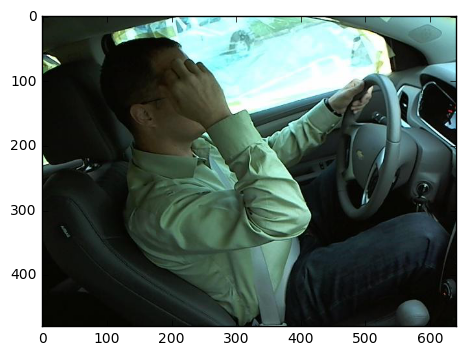

In [54]:
check_training_picture(bn_feat, filenames, 22)

This is marked as class0 - 

```
c0: normal driving
c1: texting - right
c2: talking on the phone - right
c3: texting - left
c4: talking on the phone - left
c5: operating the radio
c6: drinking
c7: reaching behind
c8: hair and makeup
c9: talking to passenger
```

That hand is probably confusing, but it's mostly the correct class.

[  5.4387e-01   9.9393e-04   6.4095e-06   3.1461e-05   3.1368e-04   1.3539e-03   3.0034e-05
   6.8933e-04   7.3784e-05   4.5264e-01]
c0/img_102087.jpg


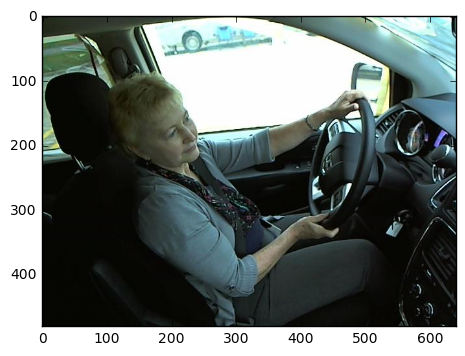

In [55]:
check_training_picture(bn_feat, filenames, 45)

This doesn't have any 'good' class, everything is low, which is weird - could be the not-straight head angle, but who knows. I just realised that some pictures have a blue tape-like thing on the driver window (see above and below), some pictures don't have that sheet, which is probably confusing.

# TODO: find a way to mask that window

[  1.4622e-01   1.4535e-03   1.7558e-05   1.5187e-04   7.7130e-05   3.3243e-03   9.7658e-06
   2.4722e-04   4.6495e-04   8.4804e-01]
c9/img_39396.jpg


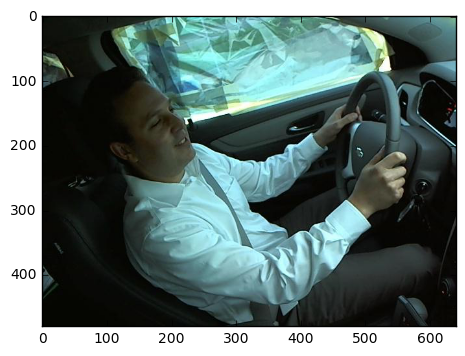

In [56]:
check_training_picture(bn_feat, filenames, 17421)

This is marked as 'talking to passenger', but it may as well be c0, driving normally.

# Kick out the 'bad' pictures
I believe that these low quality marks 'confuse' the network, so a network trained without those pictures should work slightly better.

In [67]:
to_remove = np.where(np.amax(bn_feat, axis=1) < 0.9)[0]
print(len(to_remove))
print(356./18587*100)

356
1.91531715715


356 pictures are 'weird', which is not that much compared to our 18587 pictures (roughly 2%)

In [74]:
to_remove_files = set([filenames[index] for index in to_remove])
list(to_remove_files)[:5]

['c3/img_26058.jpg',
 'c8/img_75090.jpg',
 'c4/img_81806.jpg',
 'c5/img_21645.jpg',
 'c9/img_6428.jpg']

In [81]:
print(path)
%pwd

/home/ubuntu/statefarm/


u'/home/ubuntu/statefarm'

In [83]:
%%bash
mkdir weird_ones
mkdir weird_ones/train
for i in {0..9}; do mkdir /home/ubuntu/statefarm/weird_ones/train/c${i}; done


mkdir: cannot create directory ‘weird_ones’: File exists


In [95]:
%cd /home/ubuntu/statefarm/cleaned/train
for l in glob.glob('*/*jpg'):
    if l in to_remove_files:
        os.popen('mv %s ../../weird_ones/train/%s'%(l, l))

/home/ubuntu/statefarm/cleaned/train


In [96]:
%%bash
find . -type f | wc -l

18231


OK we removed the weird ones.

In [97]:
path = "/home/ubuntu/statefarm/cleaned/"


In [98]:
batch_size = 64

gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)

trn_batches = get_batches(path+'train', gen_t, batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

Found 18231 images belonging to 10 classes.
Found 3837 images belonging to 10 classes.


In [99]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(10)

In [100]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [101]:
model.fit_generator(trn_batches, trn_batches.N, nb_epoch=3, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/3
18231/18231 [==============================] - 528s - loss: 2.9115 - acc: 0.4277 - val_loss: 2.5412 - val_acc: 0.4282
Epoch 2/3
18231/18231 [==============================] - 528s - loss: 1.9668 - acc: 0.5764 - val_loss: 3.5711 - val_acc: 0.3784
Epoch 3/3
18231/18231 [==============================] - 528s - loss: 1.8183 - acc: 0.6100 - val_loss: 3.7456 - val_acc: 0.3972


In [102]:
model.optimizer.lr = 1e-5
model.fit_generator(trn_batches, trn_batches.N, nb_epoch=3, validation_data=val_batches, 
                 nb_val_samples=val_batches.N)

Epoch 1/3
18231/18231 [==============================] - 529s - loss: 1.7448 - acc: 0.6236 - val_loss: 4.4786 - val_acc: 0.3787
Epoch 2/3
18231/18231 [==============================] - 528s - loss: 1.7338 - acc: 0.6336 - val_loss: 4.1116 - val_acc: 0.4014
Epoch 3/3
18231/18231 [==============================] - 528s - loss: 1.7705 - acc: 0.6304 - val_loss: 4.5988 - val_acc: 0.3703


In [103]:
last_conv_idx = [i for i,l in enumerate(model.layers) if type(l) is Convolution2D][-1]
conv_layers = model.layers[:last_conv_idx+1]

In [104]:
conv_model = Sequential(conv_layers)

In [105]:
trn_batches = get_batches(path+'train', gen_t, batch_size=batch_size, shuffle=False)

conv_feat = conv_model.predict_generator(trn_batches, trn_batches.nb_sample)
conv_val_feat = conv_model.predict_generator(val_batches, val_batches.nb_sample)


Found 18231 images belonging to 10 classes.


In [106]:

#print(conv_layers[-1].output_shape)
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(10, activation='softmax')
        ]



In [107]:
p = 0.8

In [108]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)


Found 18231 images belonging to 10 classes.
Found 3837 images belonging to 10 classes.
Found 0 images belonging to 10 classes.


In [109]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [110]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=1, 
             validation_data=(conv_val_feat, val_labels))


Train on 18231 samples, validate on 3837 samples
Epoch 1/1
18231/18231 [==============================] - 12s - loss: 3.1294 - acc: 0.2389 - val_loss: 1.3900 - val_acc: 0.5228


In [111]:
bn_model.optimizer.lr = 1e-5
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 18231 samples, validate on 3837 samples
Epoch 1/7
18231/18231 [==============================] - 12s - loss: 1.4303 - acc: 0.5127 - val_loss: 1.2264 - val_acc: 0.5927
Epoch 2/7
18231/18231 [==============================] - 12s - loss: 0.9601 - acc: 0.6635 - val_loss: 1.1455 - val_acc: 0.6224
Epoch 3/7
18231/18231 [==============================] - 12s - loss: 0.7579 - acc: 0.7365 - val_loss: 1.1253 - val_acc: 0.6380
Epoch 4/7
18231/18231 [==============================] - 12s - loss: 0.6412 - acc: 0.7804 - val_loss: 1.0720 - val_acc: 0.6375
Epoch 5/7
18231/18231 [==============================] - 12s - loss: 0.5638 - acc: 0.8060 - val_loss: 1.0505 - val_acc: 0.6604
Epoch 6/7
18231/18231 [==============================] - 12s - loss: 0.4995 - acc: 0.8324 - val_loss: 1.1410 - val_acc: 0.6448
Epoch 7/7
18231/18231 [==============================] - 12s - loss: 0.4717 - acc: 0.8419 - val_loss: 1.0246 - val_acc: 0.6909


In [112]:
bn_model.optimizer.lr = 1e-7
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 18231 samples, validate on 3837 samples
Epoch 1/7
18231/18231 [==============================] - 12s - loss: 0.4413 - acc: 0.8517 - val_loss: 1.0161 - val_acc: 0.6849
Epoch 2/7
18231/18231 [==============================] - 12s - loss: 0.4159 - acc: 0.8579 - val_loss: 1.0235 - val_acc: 0.6813
Epoch 3/7
18231/18231 [==============================] - 12s - loss: 0.3999 - acc: 0.8691 - val_loss: 1.0616 - val_acc: 0.6651
Epoch 4/7
18231/18231 [==============================] - 12s - loss: 0.3780 - acc: 0.8726 - val_loss: 1.0807 - val_acc: 0.6760
Epoch 5/7
18231/18231 [==============================] - 12s - loss: 0.3684 - acc: 0.8776 - val_loss: 1.1350 - val_acc: 0.6609
Epoch 6/7
18231/18231 [==============================] - 12s - loss: 0.3584 - acc: 0.8809 - val_loss: 1.1941 - val_acc: 0.6492
Epoch 7/7
18231/18231 [==============================] - 12s - loss: 0.3457 - acc: 0.8863 - val_loss: 0.9693 - val_acc: 0.6979


In [113]:
bn_model.optimizer.lr = 1e-9
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 18231 samples, validate on 3837 samples
Epoch 1/7
18231/18231 [==============================] - 12s - loss: 0.3334 - acc: 0.8887 - val_loss: 1.0327 - val_acc: 0.6844
Epoch 2/7
18231/18231 [==============================] - 12s - loss: 0.3243 - acc: 0.8933 - val_loss: 1.0689 - val_acc: 0.6914
Epoch 3/7
18231/18231 [==============================] - 12s - loss: 0.3160 - acc: 0.8936 - val_loss: 1.0157 - val_acc: 0.6977
Epoch 4/7
18231/18231 [==============================] - 12s - loss: 0.3089 - acc: 0.8966 - val_loss: 1.1417 - val_acc: 0.6669
Epoch 5/7
18231/18231 [==============================] - 12s - loss: 0.3124 - acc: 0.8962 - val_loss: 1.0857 - val_acc: 0.6807
Epoch 6/7
18231/18231 [==============================] - 12s - loss: 0.3048 - acc: 0.8995 - val_loss: 1.0619 - val_acc: 0.6946
Epoch 7/7
18231/18231 [==============================] - 12s - loss: 0.2943 - acc: 0.9018 - val_loss: 1.0417 - val_acc: 0.6956


# RESULTS
Interestingly, the validation accuracy and validation loss is VERY similar, almost identical to the above. The training accuracy is slightly better.

# TODO: Fix the validation problems too

# TRYING OUT CUTTING FROM PICTURES

In [45]:
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
img = glob.glob('train/*/*jpg')[100]

img = cv2.imread(img)

(rects, weights) = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=1.05)
for (x, y, w, h) in rects:
    cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 0, 255), 2)
rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
pick = non_max_suppression(rects, probs=None, overlapThresh=0.5)
for (xA, yA, xB, yB) in pick:
    cv2.rectangle(img, (xA, yA), (xB, yB), (0, 255, 0), 2)
#plt.imshow(img)
#cv2.imshow('hi', img)
img.save('test.png')

AttributeError: 'numpy.ndarray' object has no attribute 'save'